# Descartes Lab Mobility Changes Analysis

### Background
Reference: https://www.descarteslabs.com/wp-content/uploads/2020/03/mobility-v097.pdf<br>
DL uses anonymized
and/or de-identified mobile device locations to measure mobility,
a statistic representing the distance a typical member of a given
population moves in a day. Results indicate that a large reduction
in mobility has taken place, both in the US and globally.

$m50$: The median of the max-distance mobility for all samples in the specified region.  
$m50\_index$: The percent of normal m50 in the region, with normal m50 defined during 2020-02-17 to 2020-03-07.
$$m50\_index = 100 \times \frac{m50}{m50_{norm}}$$

In [3]:
from datetime import date, datetime, timedelta
import git
from fbprophet import Prophet
import matplotlib.pyplot as plt
import os
import pandas as pd

In [4]:
repo = git.Repo("./", search_parent_directories=True)
home_dir = repo.working_dir
data_dir = f'{home_dir}/data/us/mobility'

In [5]:
# Data contains information about states and counties with states listed before their respective counties
df = pd.read_csv(os.path.join(data_dir, 'DL-us-mobility-daterow.csv'))
df.head()

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
0,2020-03-01,US,1,Alabama,NaN,1.0,133826,8.331,79
1,2020-03-02,US,1,Alabama,NaN,1.0,143632,10.398,98
2,2020-03-03,US,1,Alabama,NaN,1.0,146009,10.538,100
3,2020-03-04,US,1,Alabama,NaN,1.0,149352,10.144,96
4,2020-03-05,US,1,Alabama,NaN,1.0,144109,10.982,104


In [6]:
df.tail()

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
96040,2020-04-01,US,2,Wyoming,Uinta County,56041.0,397,2.983,95
96041,2020-04-02,US,2,Wyoming,Uinta County,56041.0,405,3.308,105
96042,2020-04-03,US,2,Wyoming,Uinta County,56041.0,365,3.633,116
96043,2020-04-04,US,2,Wyoming,Uinta County,56041.0,375,2.153,68
96044,2020-04-05,US,2,Wyoming,Uinta County,56041.0,421,2.783,88


In [7]:
dates = df.date.unique()
states = df[df['admin_level'] == 1]
counties = df[df['admin_level'] == 2]

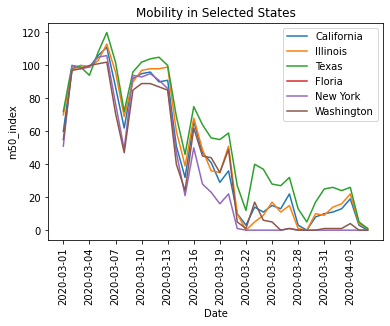

In [8]:
selected_states = ['California', 'Illinois', 'Texas', 'Floria', 'New York', 'Washington']

for state in selected_states:
    state_data = states[states['admin1'] == state]
    plt.plot(state_data['date'], state_data['m50_index'], label=state)

plt.title('Mobility in Selected States')
plt.xlabel('Date')
plt.xticks(ticks = range(0, len(dates), 3), rotation=90)
plt.ylabel('m50_index')
plt.legend()
plt.show()

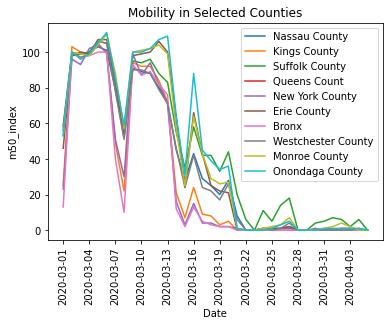

In [9]:
selected_counties = ['Nassau County', 'Kings County', 'Suffolk County', 'Queens Count', 'New York County',
                    'Erie County', 'Bronx', 'Westchester County', 'Monroe County', 'Onondaga County']

for county in selected_counties:
    county_data = counties[(counties['admin1'] == 'New York') & (counties['admin2'] == county)]
    plt.plot(county_data['date'], county_data['m50_index'], label=county)

plt.title('Mobility in Selected Counties')
plt.xlabel('Date')
plt.xticks(ticks = range(0, len(dates), 3), rotation=90)
plt.ylabel('m50_index')
plt.legend()
plt.show()

Now let's build a time series forecast of the future for the mobility index. We need this to use the mobility index as a regressor for the fbprophet package to make a forecast for county deaths. One forecast of mobility is we believe social distancing will continue and mobility index will remain around 0-5%. Let's also make a forecast where social distancing guidelines are lifted by Easter, as Trump had previously indicated that he hoped the country would be "opened up and raring to go" by Easter. We can do this by symmetrically reflecting the decrease in mobility into an increase in mobility after Easter and return to ~100%. This obviously isn't very accurate because we would expect people to slowly increase their mobility back up to 100% rather than as quickly as they began to socially distance. Let's take March 4th - March 19th as the time period for when social distancing measures take effect as it covers when mobility was last at ~100% to when levels reached <10%.

In [10]:
start_of_sd, end_of_sd = date(2020, 3, 4), date(2020, 3, 19)
sd_transition_length = end_of_sd - start_of_sd
easter = date(2020, 4, 12)
predict_until_date = easter + timedelta(days=sd_transition_length.days)

def build_sd_forecast(data):
    curr_date = datetime.strptime(max(data['date']), '%Y-%m-%d') + timedelta(days=1)
    curr_date = curr_date.date()
    
    while curr_date <= predict_until_date:
        data = data.append({'date': curr_date.strftime('%Y-%m-%d'), 'm50_index': 0}, ignore_index=True)
        curr_date += timedelta(days=1)
    
    return data
    
def build_easter_forecast(data):
    data = build_sd_forecast(data)
    curr_date = easter
    
    while curr_date <= predict_until_date:
        days_since_easter = curr_date - easter
        symmetric_date = end_of_sd - days_since_easter
        data.loc[data['date'] == curr_date.strftime('%Y-%m-%d'), ['m50_index']] = \
            data.loc[data['date'] == symmetric_date.strftime('%Y-%m-%d'), ['m50_index']]['m50_index'].values[0]
        curr_date += timedelta(days=1)
        
    return data

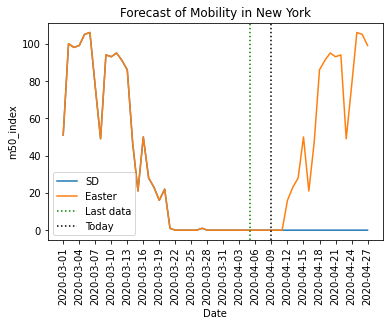

In [13]:
new_york_mobility = states[states['admin1'] == 'New York']
new_york_sd_mobility_forecast = build_sd_forecast(new_york_mobility)
new_york_easter_mobility_forecast = build_easter_forecast(new_york_mobility)

plt.plot(new_york_sd_mobility_forecast['date'], new_york_sd_mobility_forecast['m50_index'], label='SD')
plt.plot(new_york_easter_mobility_forecast['date'], new_york_easter_mobility_forecast['m50_index'], label='Easter')
plt.axvline(x=max(new_york_mobility['date']), ls=':', c='g', label='Last data')
plt.axvline(x=datetime.today().date().strftime('%Y-%m-%d'), ls=':', c='k', label='Today')

plt.title('Forecast of Mobility in New York')
plt.xlabel('Date')
plt.xticks(ticks = range(0, len(new_york_sd_mobility_forecast), 3), rotation=90)
plt.ylabel('m50_index')
plt.legend()
plt.show()

By now, we have a pretty good idea of the decrease in mobility due to social distancing and stay-at-home policies starting heavily around March 3rd, 2020. But how can we use this to predict deaths? First, let's take a look at the NYT deaths dataset for states and counties and see if we notice any trends.

In [24]:
deaths_data_dir = f'{home_dir}/data/us/covid/'
counties_deaths = pd.read_csv(os.path.join(deaths_data_dir, 'nyt_us_counties.csv'))
states_deaths = pd.read_csv(os.path.join(deaths_data_dir, 'nyt_us_states.csv'))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


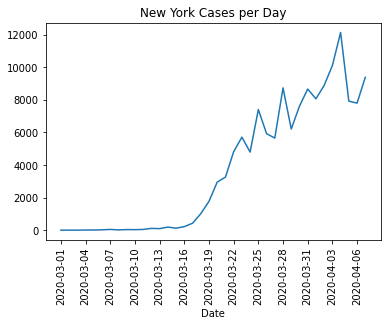

In [26]:
new_york_deaths = states_deaths[states_deaths['fips'] == 36]

def uncumulate(deaths):
    res = [deaths[0]]
    
    for i, death in enumerate(deaths[1:]):
        res.append(death - deaths[i])
        
    return res

plt.plot(new_york_deaths['date'], uncumulate(new_york_deaths['cases'].tolist()))
plt.title('New York Cases per Day')
plt.xlabel('Date')
plt.xticks(ticks = range(0, len(new_york_deaths.date.unique()), 3), rotation=90)
plt.show()

Now we use the Facebook open source package for time series forcasting procedure. It is best with time series that have strong seasonal effects and several seasons of historical data. Because of this, this model could be used to predict future seasonal outbreaks of COVID-19.

In [27]:
def build_prophet_df(df, value_column, regressor=None):
    """
    @param df:
    @param value_column:
    @param regressor
    """
    df = df[['date', value_column]]
    if regressor is not None:
        df['regressor'] = df['date'].apply(lambda date: regressor.loc[regressor['date'] == date, 'm50_index'].values[0])
    df = df.rename(columns={'date':'ds', value_column: 'y'})
    return df

def build_prophet_forecast(df, value_column, regressor=None, periods=10):
    """
    Returns a Prophet object fitted to the given df. df should have columns with date and m50_index.
    
    @param df: Pandas dataframe to predict forecast.
    @param value_column:
    @param regressor: regressor used to predict forecast. Example: using mobility index regressor
    to predict county deaths.
    @param periods: number of periods (days) to predict into the future.
    """
    m = Prophet()
    if regressor is not None:
        m.add_regressor('regressor')
    m.fit(build_prophet_df(df, value_column=value_column, regressor=regressor))
    future = m.make_future_dataframe(periods=periods)
    if regressor is not None:
        future['regressor'] = future['ds'].apply(lambda date: regressor.loc[regressor['date'] == date, 'm50_index'].values[0])
    forecast = m.predict(future)
    return m, forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


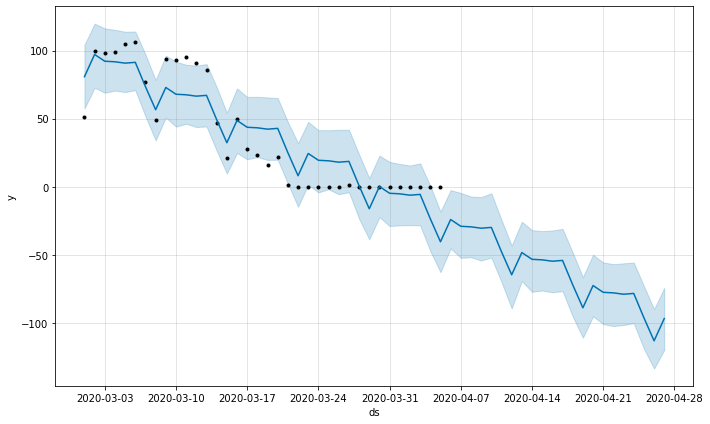

In [34]:
m, forecast = build_prophet_forecast(new_york_mobility, 'm50_index', periods=22)
fig1 = m.plot(forecast)

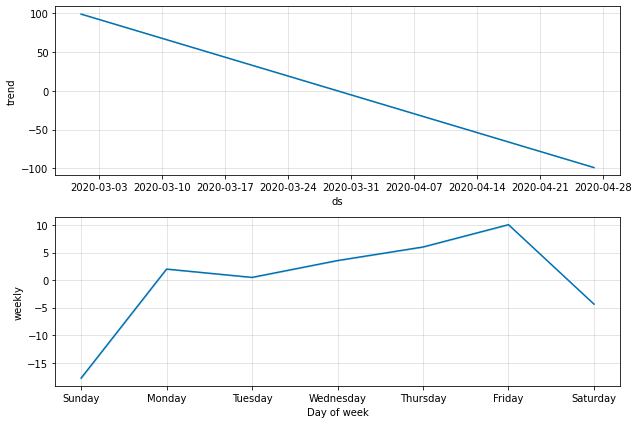

In [31]:
fig2 = m.plot_components(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


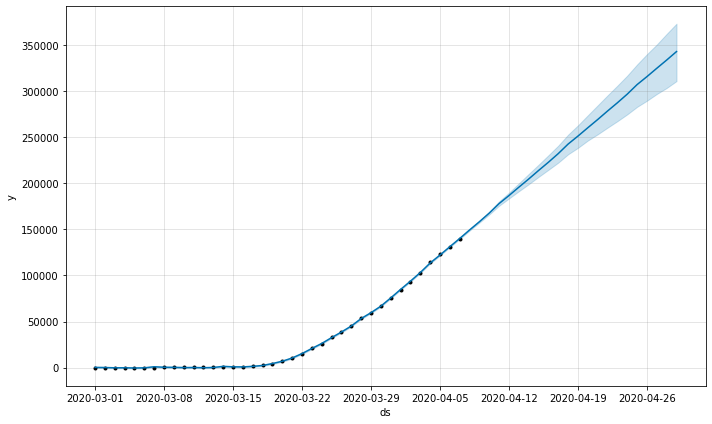

In [28]:
m, forecast = build_prophet_forecast(new_york_deaths, 'cases', periods=22)
fig1 = m.plot(forecast)

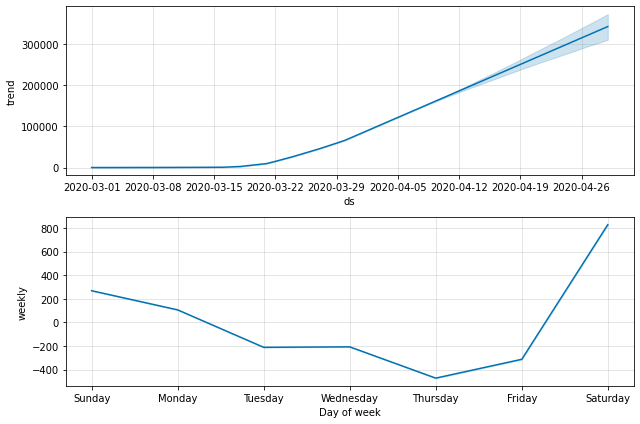

In [29]:
fig2 = m.plot_components(forecast)

### Extensions
* Use the mobiltiy time series as a regressor for cases/deaths time series for prediction. 